In [625]:
import re
import os
import pickle
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import pandas as pd
import numpy as np

In [626]:
# Get SQL query file as data input 
def get_sql_file_as_text(file_path):
  
  with open(file_path, 'r') as f:
    sql_content = f.read()
  return sql_content

In [627]:
# Establish connection with Snowflake
conn = snowflake.connector.connect(connection_name="fundingsociety.sg.ap-southeast-1.aws.privatelink")

### F&B

In [427]:
# Write SQL Snowflake Query here
sql_file = "Industry Seg - EDA - F&B.sql"
sql_text = get_sql_file_as_text(sql_file)
my_query=sql_text

In [428]:
# Get data from query above
df_fnb = conn.cursor().execute(my_query).fetch_pandas_all()

In [429]:
df_fnb.set_index('COMPANY_ID', inplace=True)

In [430]:
#ENCODING OF L2 INDUSTRY

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
df_fnb['CU_COMPANY_L2_INDUSTRY_NUMERIC'] = label_encoder.fit_transform(df_fnb['CU_COMPANY_L2_INDUSTRY'])

# Drop old var
df_fnb = df_fnb.drop('CU_COMPANY_L2_INDUSTRY', axis=1)

In [431]:
#IMPUT MISSING VALUE INTO RSD_PERCENTAGE_MAKE

mean_value = df_fnb['RSD_PERCENTAGE_MAKE'].mean()
df_fnb['RSD_PERCENTAGE_MAKE'].fillna(mean_value, inplace=True)

In [432]:
df_fnb.head()

,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,
1923,4243.256234140000,29.355280130000,3.000000,2,0.666667,0.333333,0.000000,36,36,0.861879,1,2
1925,702.346078900556,2.830569822222,49.500000,2,0.994949,0.005051,0.000000,36,33,1.535244,0,3
1387,1024.060875220465,2.615673902907,6.615385,1,1.000000,0.000000,0.000000,49,37,0.629385,0,3
2252,7320.245602459167,31.671267549167,0.428571,1,1.000000,0.000000,0.000000,31,4,1.589166,0,3
2434,1936.606748443125,17.577897816875,2.666667,3,0.437500,0.000000,0.125000,28,23,1.521705,1,3


In [433]:
df_fnb_segmentation = df_fnb[['AVG_USD_AMT_ALL_MAKE',
                              'FREQ_ACTIVE_MAKE',
                              'PAYTYPE_COUNT_ALL_MAKE',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE',
                              'RSD_PERCENTAGE_MAKE']].copy()

In [434]:
df_fnb_segmentation_lapsed = df_fnb_segmentation[df_fnb_segmentation['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] > 12]
df_fnb_segmentation_active = df_fnb_segmentation[df_fnb_segmentation['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] <= 12]

In [435]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Min-max scale the numerical columns in df_fnb_numerical
df_fnb_segmentation_active_scaled = pd.DataFrame(scaler.fit_transform(df_fnb_segmentation_active),
                                                 columns=df_fnb_segmentation_active.columns,
                                                 index=df_fnb_segmentation_active.index)


# Min-max scale the numerical columns in df_fnb_numerical
df_fnb_segmentation_lapsed_scaled = pd.DataFrame(scaler.fit_transform(df_fnb_segmentation_lapsed),
                                                 columns=df_fnb_segmentation_lapsed.columns,
                                                 index=df_fnb_segmentation_lapsed.index)

WCSS for k=2: 60.76576687259542
WCSS for k=3: 59.1728152180919
WCSS for k=4: 58.19277103637403
WCSS for k=5: 55.61957558806726
WCSS for k=6: 39.430442995835854
WCSS for k=7: 38.797350292248254
WCSS for k=8: 36.35794796453976
WCSS for k=9: 37.07332833690647
WCSS for k=10: 33.65021062579766


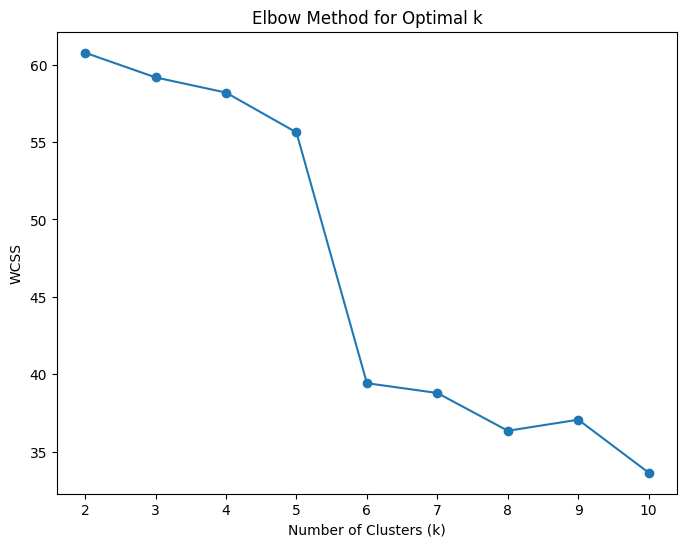


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
2252          7320.245602459167         0.428571                       1   
1889          4089.344189075676         2.055556                       1   
4426          6176.293613545000         1.000000                       1   
4321          3236.328577356346        10.400000                       2   
4675          5455.957624040000         1.500000                       1   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  Cluster  
COMPANY_ID                                                                    
2252                                         4             1.589166        1  
1889                                         0             0.277566        3  
4426                                         0         

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/1663374817.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fnb_segmentation_active['Cluster'] = labels


In [436]:
#SEGMENTATION OF ACTIVE CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_fnb_segmentation_active_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_fnb_segmentation_active_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_fnb_segmentation_active['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_fnb_segmentation_active.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_fnb_segmentation_active['Cluster'].value_counts())


WCSS for k=2: 41.31367628283347
WCSS for k=3: 39.22176927466181
WCSS for k=4: 38.167204726514704
WCSS for k=5: 29.84477942080744
WCSS for k=6: 28.9913928611652
WCSS for k=7: 30.745424205285016
WCSS for k=8: 26.08954918973776
WCSS for k=9: 25.63552875884723
WCSS for k=10: 25.50274294337276


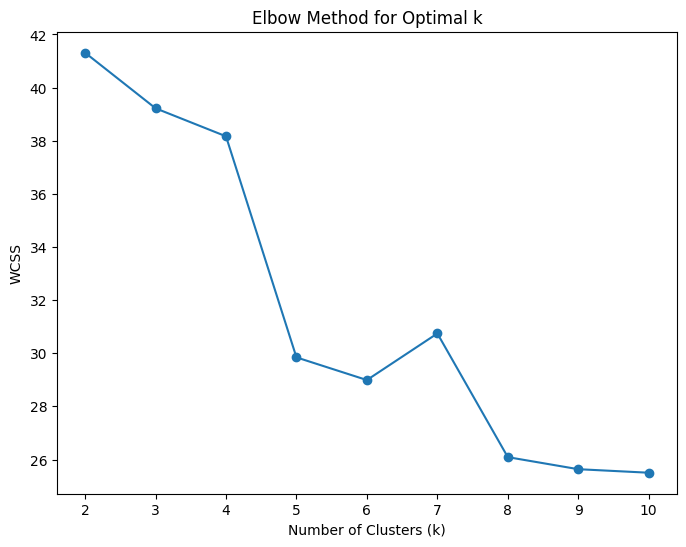


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
1923          4243.256234140000         3.000000                       2   
1925           702.346078900556        49.500000                       2   
1387          1024.060875220465         6.615385                       1   
2434          1936.606748443125         2.666667                       3   
2427          8864.366218983000         1.428571                       1   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
1923                                        36             0.861879   
1925                                        33             1.535244   
1387                                        37             0.629385   
2434            

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2172573720.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fnb_segmentation_lapsed['Cluster_Lapsed'] = labels


In [437]:
#SEGMENTATION OF LAPSED CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_fnb_segmentation_lapsed_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_fnb_segmentation_lapsed_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_fnb_segmentation_lapsed['Cluster_Lapsed'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_fnb_segmentation_lapsed.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_fnb_segmentation_lapsed['Cluster_Lapsed'].value_counts())


In [438]:
import pandas as pd

# Assuming df_fnb_segmentation_lapsed and df_fnb_segmentation_active are your dataframes

# Step 1: Create new cluster columns with the combined labels (e.g., lapsed_2, active_2)
df_fnb_segmentation_lapsed['Combined_Cluster'] = 'lapsed_' + df_fnb_segmentation_lapsed['Cluster_Lapsed'].astype(str)
df_fnb_segmentation_active['Combined_Cluster'] = 'active_' + df_fnb_segmentation_active['Cluster'].astype(str)

# Step 3: Keep the original indices when concatenating
df_fnb_segmentation_lapsed_x = df_fnb_segmentation_lapsed.reset_index(drop=False).copy()  # Keep original index as a column
df_fnb_segmentation_active_x = df_fnb_segmentation_active.reset_index(drop=False).copy()  # Keep original index as a column

# Step 4: Concatenate the two dataframes along rows (axis=0)
df_fnb_segmentation = pd.concat([df_fnb_segmentation_lapsed_x, df_fnb_segmentation_active_x], axis=0, ignore_index=False)

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/907335047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fnb_segmentation_lapsed['Combined_Cluster'] = 'lapsed_' + df_fnb_segmentation_lapsed['Cluster_Lapsed'].astype(str)
/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/907335047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fnb_segmentation_active['Combined_Cluster'] = 'active_' + df_fnb_segmentation_active['Cluster'].astype(str)


In [439]:
df_fnb_segmentation.set_index('COMPANY_ID', inplace=True)
df_fnb_segmentation = df_fnb_segmentation[['Combined_Cluster']]
df_fnb_segmentation.head()

,Combined_Cluster
COMPANY_ID,
1923,lapsed_3
1925,lapsed_3
1387,lapsed_1
2434,lapsed_3
2427,lapsed_2


In [440]:
# Reset the index to make COMPANY_ID a column in both dataframes
df_fnb_reset = df_fnb.reset_index()  # This will move the index to a column
df_fnb_segmentation_reset = df_fnb_segmentation.reset_index()  # Same for df_fnb_segmentation

# Now perform the merge
df_fnb = df_fnb_reset.merge(df_fnb_segmentation_reset[['COMPANY_ID', 'Combined_Cluster']], on='COMPANY_ID', how='left')

# Optionally, set COMPANY_ID back as the index if you want it to be the index again
df_fnb.set_index('COMPANY_ID', inplace=True)

# Display the merged dataframe
df_fnb.head()


,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC,Combined_Cluster
COMPANY_ID,,,,,,,,,,,,,
1923,4243.256234140000,29.355280130000,3.000000,2,0.666667,0.333333,0.000000,36,36,0.861879,1,2,lapsed_3
1925,702.346078900556,2.830569822222,49.500000,2,0.994949,0.005051,0.000000,36,33,1.535244,0,3,lapsed_3
1387,1024.060875220465,2.615673902907,6.615385,1,1.000000,0.000000,0.000000,49,37,0.629385,0,3,lapsed_1
2252,7320.245602459167,31.671267549167,0.428571,1,1.000000,0.000000,0.000000,31,4,1.589166,0,3,active_1
2434,1936.606748443125,17.577897816875,2.666667,3,0.437500,0.000000,0.125000,28,23,1.521705,1,3,lapsed_3


In [441]:
df_fnb.to_csv('fnb_clustered.csv')

### Education for Acq

In [442]:
# Write SQL Snowflake Query here
sql_file = "Industry Seg - EDA - Educ.sql"
sql_text = get_sql_file_as_text(sql_file)
my_query=sql_text

In [443]:
# Get data from query above
df_educ = conn.cursor().execute(my_query).fetch_pandas_all()

In [444]:
df_educ.set_index('COMPANY_ID', inplace=True)

In [445]:
#ENCODING OF L2 INDUSTRY

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
df_educ['CU_COMPANY_L2_INDUSTRY_NUMERIC'] = label_encoder.fit_transform(df_educ['CU_COMPANY_L2_INDUSTRY'])

# Drop old var
df_educ = df_educ.drop('CU_COMPANY_L2_INDUSTRY', axis=1)

In [446]:
#IMPUT MISSING VALUE INTO RSD_PERCENTAGE_MAKE

mean_value = df_educ['RSD_PERCENTAGE_MAKE'].mean()
df_educ['RSD_PERCENTAGE_MAKE'].fillna(mean_value, inplace=True)

In [447]:
df_educ.head()

,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,ENTITY_NAME,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,,
4403,13445.356080163333,149.359784420000,0.750000,1,0.000000,0.000000,1.000000,4,1,0.191308,0,OON GROUP PTE. LTD.,1
4680,28465.844177210000,104.474422030000,1.000000,1,0.000000,0.000000,0.000000,0,0,0.841133,0,LORNA WHISTON PRE-SCHOOL EDUCATION PTE LTD,1
344,20194.291184893913,-124.117817065000,1.586207,1,0.000000,1.000000,0.000000,28,0,0.509655,0,EMILE PRESCHOOL PTE. LTD.,1
3795,2337.993174386000,7.994344358000,6.875000,2,0.800000,0.200000,0.000000,7,0,0.653369,0,THE NUGGETS ACADEMY PTE. LTD.,1
4303,7595.594978400000,-9.343362050000,2.000000,1,1.000000,0.000000,0.000000,5,5,0.841133,0,DASHSTAR PTE. LTD.,1


In [448]:
df_educ_seg = df_educ[['AVG_USD_AMT_ALL_MAKE',
                              'FREQ_ACTIVE_MAKE',
                              'PAYTYPE_COUNT_ALL_MAKE',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE',
                              'RSD_PERCENTAGE_MAKE']].copy()

In [449]:
df_educ_seg_lapsed = df_educ_seg[df_educ_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] > 12]
df_educ_seg_active = df_educ_seg[df_educ_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] <= 12]

In [450]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Min-max scale the numerical columns in df_fnb_numerical
df_educ_seg_active_scaled = pd.DataFrame(scaler.fit_transform(df_educ_seg_active),
                                                 columns=df_educ_seg_active.columns,
                                                 index=df_educ_seg_active.index)


# Min-max scale the numerical columns in df_fnb_numerical
df_educ_seg_lapsed_scaled = pd.DataFrame(scaler.fit_transform(df_educ_seg_lapsed),
                                                 columns=df_educ_seg_lapsed.columns,
                                                 index=df_educ_seg_lapsed.index)

In [451]:
df_educ_seg_lapsed.shape

(18, 5)

WCSS for k=2: 12.58392863097693
WCSS for k=3: 10.746946762378109
WCSS for k=4: 9.508890659005086
WCSS for k=5: 8.160542227998471
WCSS for k=6: 7.622687691142337
WCSS for k=7: 6.941015462976742
WCSS for k=8: 6.6976135621902
WCSS for k=9: 6.410185413865568
WCSS for k=10: 6.000218666135834


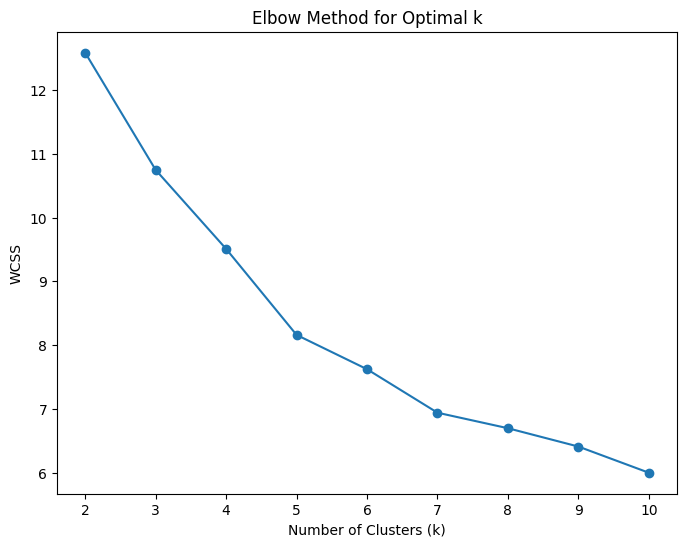


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
4403         13445.356080163333         0.750000                       1   
4680         28465.844177210000         1.000000                       1   
344          20194.291184893913         1.586207                       1   
3795          2337.993174386000         6.875000                       2   
4303          7595.594978400000         2.000000                       1   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  Cluster  
COMPANY_ID                                                                    
4403                                         1             0.191308        0  
4680                                         0             0.841133        3  
344                                          0         

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2104456992.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_educ_seg_active['Cluster'] = labels


In [452]:
#SEGMENTATION OF ACTIVE CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_educ_seg_active_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_educ_seg_active_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_educ_seg_active['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_educ_seg_active.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_educ_seg_active['Cluster'].value_counts())


WCSS for k=2: 9.538181222342663
WCSS for k=3: 7.007333403333999
WCSS for k=4: 6.900304753431932
WCSS for k=5: 6.654837601842383
WCSS for k=6: 6.577440608030718
WCSS for k=7: 6.508937244995483
WCSS for k=8: 6.272039078242754
WCSS for k=9: 6.129568600985687
WCSS for k=10: 6.062456326751693


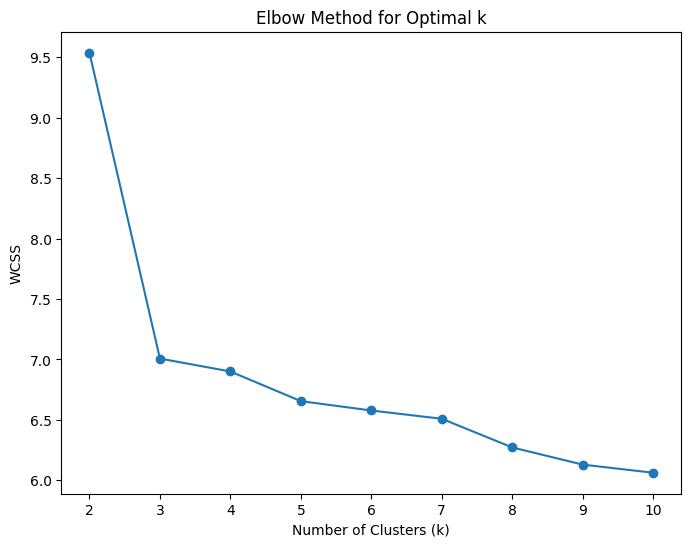


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
961           2469.476647000000         1.000000                       1   
915           6886.541750000000         0.400000                       1   
2539          3945.802300000000         1.000000                       1   
2766          3573.556800000000         1.000000                       1   
713          10663.775447365957         1.740741                       3   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
961                                         59             0.841133   
915                                         57             0.841133   
2539                                        25             0.841133   
2766            

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/3155950802.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_educ_seg_lapsed['Cluster_Lapsed'] = labels


In [453]:
#SEGMENTATION OF LAPSED CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_educ_seg_lapsed_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_educ_seg_lapsed_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_educ_seg_lapsed['Cluster_Lapsed'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_educ_seg_lapsed.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_educ_seg_lapsed['Cluster_Lapsed'].value_counts())


In [454]:
import pandas as pd

# Assuming df_fnb_segmentation_lapsed and df_fnb_segmentation_active are your dataframes

# Step 1: Create new cluster columns with the combined labels (e.g., lapsed_2, active_2)
df_educ_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_educ_seg_lapsed['Cluster_Lapsed'].astype(str)
df_educ_seg_active['Combined_Cluster'] = 'active_' + df_educ_seg_active['Cluster'].astype(str)

# Step 3: Keep the original indices when concatenating
df_educ_seg_lapsed_x = df_educ_seg_lapsed.reset_index(drop=False).copy()  # Keep original index as a column
df_educ_seg_active_x = df_educ_seg_active.reset_index(drop=False).copy()  # Keep original index as a column

# Step 4: Concatenate the two dataframes along rows (axis=0)
df_educ_seg = pd.concat([df_educ_seg_lapsed_x, df_educ_seg_active_x], axis=0, ignore_index=False)

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/1311130778.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_educ_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_educ_seg_lapsed['Cluster_Lapsed'].astype(str)
/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/1311130778.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_educ_seg_active['Combined_Cluster'] = 'active_' + df_educ_seg_active['Cluster'].astype(str)


In [455]:
df_educ_seg.set_index('COMPANY_ID', inplace=True)
df_educ_seg = df_educ_seg[['Combined_Cluster']]
df_educ_seg.head()

,Combined_Cluster
COMPANY_ID,
961,lapsed_0
915,lapsed_0
2539,lapsed_2
2766,lapsed_2
713,lapsed_1


In [456]:
# Reset the index to make COMPANY_ID a column in both dataframes
df_educ_reset = df_educ.reset_index()  # This will move the index to a column
df_educ_seg_reset = df_educ_seg.reset_index()  # Same for df_fnb_segmentation

# Now perform the merge
df_educ = df_educ_reset.merge(df_educ_seg_reset[['COMPANY_ID', 'Combined_Cluster']], on='COMPANY_ID', how='left')

# Optionally, set COMPANY_ID back as the index if you want it to be the index again
df_educ.set_index('COMPANY_ID', inplace=True)

# Display the merged dataframe
df_educ.head()


,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,ENTITY_NAME,CU_COMPANY_L2_INDUSTRY_NUMERIC,Combined_Cluster
COMPANY_ID,,,,,,,,,,,,,,
4403,13445.356080163333,149.359784420000,0.750000,1,0.000000,0.000000,1.000000,4,1,0.191308,0,OON GROUP PTE. LTD.,1,active_0
4680,28465.844177210000,104.474422030000,1.000000,1,0.000000,0.000000,0.000000,0,0,0.841133,0,LORNA WHISTON PRE-SCHOOL EDUCATION PTE LTD,1,active_3
344,20194.291184893913,-124.117817065000,1.586207,1,0.000000,1.000000,0.000000,28,0,0.509655,0,EMILE PRESCHOOL PTE. LTD.,1,active_0
3795,2337.993174386000,7.994344358000,6.875000,2,0.800000,0.200000,0.000000,7,0,0.653369,0,THE NUGGETS ACADEMY PTE. LTD.,1,active_1
4303,7595.594978400000,-9.343362050000,2.000000,1,1.000000,0.000000,0.000000,5,5,0.841133,0,DASHSTAR PTE. LTD.,1,active_2


In [457]:
df_educ.to_csv('educ_clustered.csv')

### Healthcare CrossSell!

In [458]:
# Write SQL Snowflake Query here
sql_file = "Industry Seg - EDA - Healthcare.sql"
sql_text = get_sql_file_as_text(sql_file)
my_query=sql_text

In [459]:
# Get data from query above
df_hc = conn.cursor().execute(my_query).fetch_pandas_all()

In [460]:
df_hc.set_index('COMPANY_ID', inplace=True)

In [461]:
#ENCODING OF L2 INDUSTRY

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
df_hc['CU_COMPANY_L2_INDUSTRY_NUMERIC'] = label_encoder.fit_transform(df_hc['CU_COMPANY_L2_INDUSTRY'])

# Drop old var
df_hc = df_hc.drop('CU_COMPANY_L2_INDUSTRY', axis=1)

In [462]:
#IMPUT MISSING VALUE INTO RSD_PERCENTAGE_MAKE

mean_value = df_hc['RSD_PERCENTAGE_MAKE'].mean()
df_hc['RSD_PERCENTAGE_MAKE'].fillna(mean_value, inplace=True)

In [463]:
df_hc.head()

,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,ENTITY_NAME,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,,
2243,9768.913105600000,27.691342745000,0.500000,1,1.000000,0.000000,0.000000,28,25,0.689144,0,FAMILY PODIATRY CENTRE PTE. LTD.,1
2562,32609.959279744898,146.417373663673,1.960000,3,0.653061,0.163265,0.183673,25,1,0.398072,0,CUTIS MEDICAL LASER CLINICS PTE. LTD.,1
1003,5513.005180817138,13.847479985795,4.796610,3,0.950530,0.000000,0.000000,58,0,0.232562,0,FONDACO PTE LTD,1
4186,10893.299250625000,49.909746026250,2.285714,4,0.125000,0.375000,0.437500,6,0,0.556969,0,JUST KIDS DENTAL CLINIC PTE. LTD.,1
2128,4668.516938250000,-9.090235110000,0.060606,2,0.500000,0.000000,0.500000,32,0,0.689144,0,TEETH. Q DENTAL SURGEONS PTE. LTD.,1


In [464]:
df_hc_seg = df_hc[['AVG_USD_AMT_ALL_MAKE',
                              'FREQ_ACTIVE_MAKE',
                              'PAYTYPE_COUNT_ALL_MAKE',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE',
                              'RSD_PERCENTAGE_MAKE',
                              'USE_COLLECT']].copy()

In [465]:
df_hc_seg_lapsed = df_hc_seg[df_hc_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] > 12]
df_hc_seg_active = df_hc_seg[df_hc_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] <= 12]

In [466]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Min-max scale the numerical columns in df_fnb_numerical
df_hc_seg_active_scaled = pd.DataFrame(scaler.fit_transform(df_hc_seg_active),
                                                 columns=df_hc_seg_active.columns,
                                                 index=df_hc_seg_active.index)


# Min-max scale the numerical columns in df_fnb_numerical
df_hc_seg_lapsed_scaled = pd.DataFrame(scaler.fit_transform(df_hc_seg_lapsed),
                                                 columns=df_hc_seg_lapsed.columns,
                                                 index=df_hc_seg_lapsed.index)

In [467]:
df_hc_seg_lapsed.shape

(35, 6)

WCSS for k=2: 39.24059925870126
WCSS for k=3: 34.734725877712336
WCSS for k=4: 32.85186441636141
WCSS for k=5: 31.336307484954016
WCSS for k=6: 30.00682190023994
WCSS for k=7: 28.015036079644606
WCSS for k=8: 26.442500151924236
WCSS for k=9: 25.418799830942948
WCSS for k=10: 24.03377961998514


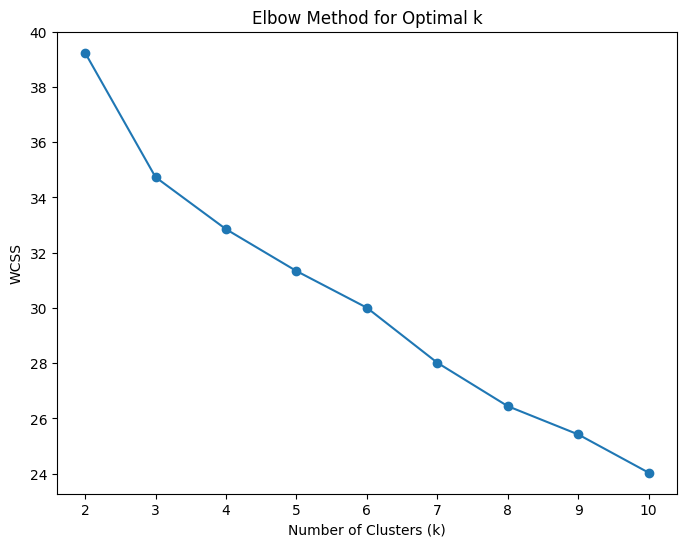


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
2562         32609.959279744898         1.960000                       3   
1003          5513.005180817138         4.796610                       3   
4186         10893.299250625000         2.285714                       4   
2128          4668.516938250000         0.060606                       2   
4000         17124.521410150000         2.250000                       2   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
2562                                         1             0.398072   
1003                                         0             0.232562   
4186                                         0             0.556969   
2128            

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/532958675.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hc_seg_active['Cluster'] = labels


In [468]:
#SEGMENTATION OF ACTIVE CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_hc_seg_active_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_hc_seg_active_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_hc_seg_active['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_hc_seg_active.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_hc_seg_active['Cluster'].value_counts())


WCSS for k=2: 14.343163959344789
WCSS for k=3: 13.460265161129026
WCSS for k=4: 12.942462065473823
WCSS for k=5: 11.632488158703094
WCSS for k=6: 11.050277297664156
WCSS for k=7: 10.36076808027969
WCSS for k=8: 9.645962097832928
WCSS for k=9: 9.195011369763941
WCSS for k=10: 8.886467528059603


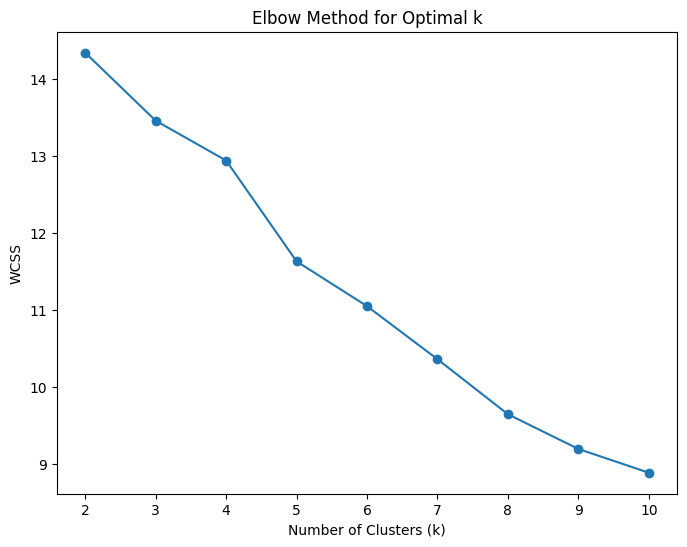


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
2243          9768.913105600000         0.500000                       1   
921           1116.736500000000         1.000000                       1   
3406          7444.910000000000         1.000000                       1   
2533         23977.912837147500         0.615385                       3   
3001          4077.329043333333         3.000000                       1   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
2243                                        25             0.689144   
921                                         60             0.689144   
3406                                        14             0.689144   
2533            

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2680432288.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hc_seg_lapsed['Cluster_Lapsed'] = labels


In [469]:
#SEGMENTATION OF LAPSED CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_hc_seg_lapsed_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_hc_seg_lapsed_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_hc_seg_lapsed['Cluster_Lapsed'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_hc_seg_lapsed.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_hc_seg_lapsed['Cluster_Lapsed'].value_counts())


In [470]:
import pandas as pd

# Assuming df_fnb_segmentation_lapsed and df_fnb_segmentation_active are your dataframes

# Step 1: Create new cluster columns with the combined labels (e.g., lapsed_2, active_2)
df_hc_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_hc_seg_lapsed['Cluster_Lapsed'].astype(str)
df_hc_seg_active['Combined_Cluster'] = 'active_' + df_hc_seg_active['Cluster'].astype(str)

# Step 3: Keep the original indices when concatenating
df_hc_seg_lapsed_x = df_hc_seg_lapsed.reset_index(drop=False).copy()  # Keep original index as a column
df_hc_seg_active_x = df_hc_seg_active.reset_index(drop=False).copy()  # Keep original index as a column

# Step 4: Concatenate the two dataframes along rows (axis=0)
df_hc_seg = pd.concat([df_hc_seg_lapsed_x, df_hc_seg_active_x], axis=0, ignore_index=False)

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/1735077053.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hc_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_hc_seg_lapsed['Cluster_Lapsed'].astype(str)
/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/1735077053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hc_seg_active['Combined_Cluster'] = 'active_' + df_hc_seg_active['Cluster'].astype(str)


In [471]:
df_hc_seg.set_index('COMPANY_ID', inplace=True)
df_hc_seg = df_hc_seg[['Combined_Cluster']]
df_hc_seg.head()

,Combined_Cluster
COMPANY_ID,
2243,lapsed_2
921,lapsed_1
3406,lapsed_3
2533,lapsed_2
3001,lapsed_3


In [472]:
# Reset the index to make COMPANY_ID a column in both dataframes
df_hc_reset = df_hc.reset_index()  # This will move the index to a column
df_hc_seg_reset = df_hc_seg.reset_index()  # Same for df_fnb_segmentation

# Now perform the merge
df_hc = df_hc_reset.merge(df_hc_seg_reset[['COMPANY_ID', 'Combined_Cluster']], on='COMPANY_ID', how='left')

# Optionally, set COMPANY_ID back as the index if you want it to be the index again
df_hc.set_index('COMPANY_ID', inplace=True)

# Display the merged dataframe
df_hc.head()


,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,ENTITY_NAME,CU_COMPANY_L2_INDUSTRY_NUMERIC,Combined_Cluster
COMPANY_ID,,,,,,,,,,,,,,
2243,9768.913105600000,27.691342745000,0.500000,1,1.000000,0.000000,0.000000,28,25,0.689144,0,FAMILY PODIATRY CENTRE PTE. LTD.,1,lapsed_2
2562,32609.959279744898,146.417373663673,1.960000,3,0.653061,0.163265,0.183673,25,1,0.398072,0,CUTIS MEDICAL LASER CLINICS PTE. LTD.,1,active_0
1003,5513.005180817138,13.847479985795,4.796610,3,0.950530,0.000000,0.000000,58,0,0.232562,0,FONDACO PTE LTD,1,active_0
4186,10893.299250625000,49.909746026250,2.285714,4,0.125000,0.375000,0.437500,6,0,0.556969,0,JUST KIDS DENTAL CLINIC PTE. LTD.,1,active_0
2128,4668.516938250000,-9.090235110000,0.060606,2,0.500000,0.000000,0.500000,32,0,0.689144,0,TEETH. Q DENTAL SURGEONS PTE. LTD.,1,active_3


In [473]:
df_hc.to_csv('hc_clustered.csv')

### Wholesale CrossSell!

In [601]:
# Write SQL Snowflake Query here
sql_file = "Industry Seg - EDA - WS.sql"
sql_text = get_sql_file_as_text(sql_file)
my_query=sql_text

In [602]:
# Get data from query above
df_ws = conn.cursor().execute(my_query).fetch_pandas_all()

In [603]:
df_ws.set_index('COMPANY_ID', inplace=True)

In [604]:
#ENCODING OF L2 INDUSTRY

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
df_ws['CU_COMPANY_L2_INDUSTRY_NUMERIC'] = label_encoder.fit_transform(df_ws['CU_COMPANY_L2_INDUSTRY'])

# Drop old var
df_ws = df_ws.drop('CU_COMPANY_L2_INDUSTRY', axis=1)

In [605]:
df_ws.head()

,AVG_USD_AMT_ALL_MAKE,AVG_REVENUE_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,...,AVG_REVENUE_USD_AMT_ALL_COLLECT,AVG_NET_REVENUE_USD_AMT_ALL_COLLECT,FREQ_ACTIVE_COLLECT,PAYTYPE_COUNT_ALL_COLLECT,SUPPLIER_PAYMENT_PERCENT_COLLECT,RENT_PAYMENT_PERCENT_COLLECT,PAYROLL_PAYMENT_PERCENT_COLLECT,MONTHS_SINCE_FIRST_PAYMENT_ALL_COLLECT,MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,,,,,,,,,,
815,3170.035233090000,58.643556070000,14.599468510000,1.000000,1.0,0.000000,0.000000,0.000000,23.0,23.0,...,None,None,None,NaN,None,None,None,NaN,NaN,0
1514,6215.273444248846,109.598524508846,16.213009581154,2.000000,1.0,1.000000,0.000000,0.000000,45.0,33.0,...,None,None,None,NaN,None,None,None,NaN,NaN,0
3457,37603.494243895250,707.267845920625,31.627187477875,5.714286,4.0,0.812500,0.000000,0.037500,13.0,0.0,...,None,None,None,NaN,None,None,None,NaN,NaN,0
863,10410.403775750000,196.218047960000,-24.694766470000,1.000000,1.0,0.000000,0.000000,0.000000,61.0,61.0,...,None,None,None,NaN,None,None,None,NaN,NaN,0
3009,7444.910000000000,96.783830000000,-73.451482060000,1.000000,1.0,1.000000,0.000000,0.000000,17.0,17.0,...,None,None,None,NaN,None,None,None,NaN,NaN,0


In [606]:
#IMPUT MISSING VALUE INTO RSD_PERCENTAGE_MAKE

mean_value = df_ws['RSD_PERCENTAGE_MAKE'].mean()
df_ws['RSD_PERCENTAGE_MAKE'].fillna(mean_value, inplace=True)

In [607]:
#IMPUT ALL ELSE MISSING as 0
df_ws_filled = df_ws.fillna(0)

In [608]:
df_ws_filled.head()

,AVG_USD_AMT_ALL_MAKE,AVG_REVENUE_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,...,AVG_REVENUE_USD_AMT_ALL_COLLECT,AVG_NET_REVENUE_USD_AMT_ALL_COLLECT,FREQ_ACTIVE_COLLECT,PAYTYPE_COUNT_ALL_COLLECT,SUPPLIER_PAYMENT_PERCENT_COLLECT,RENT_PAYMENT_PERCENT_COLLECT,PAYROLL_PAYMENT_PERCENT_COLLECT,MONTHS_SINCE_FIRST_PAYMENT_ALL_COLLECT,MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,,,,,,,,,,
815,3170.035233090000,58.643556070000,14.599468510000,1.000000,1.0,0.000000,0.000000,0.000000,23.0,23.0,...,0,0,0,0.0,0,0,0,0.0,0.0,0
1514,6215.273444248846,109.598524508846,16.213009581154,2.000000,1.0,1.000000,0.000000,0.000000,45.0,33.0,...,0,0,0,0.0,0,0,0,0.0,0.0,0
3457,37603.494243895250,707.267845920625,31.627187477875,5.714286,4.0,0.812500,0.000000,0.037500,13.0,0.0,...,0,0,0,0.0,0,0,0,0.0,0.0,0
863,10410.403775750000,196.218047960000,-24.694766470000,1.000000,1.0,0.000000,0.000000,0.000000,61.0,61.0,...,0,0,0,0.0,0,0,0,0.0,0.0,0
3009,7444.910000000000,96.783830000000,-73.451482060000,1.000000,1.0,1.000000,0.000000,0.000000,17.0,17.0,...,0,0,0,0.0,0,0,0,0.0,0.0,0


In [609]:
df_ws_filled_seg = df_ws_filled[['AVG_USD_AMT_ALL_MAKE',
                              'FREQ_ACTIVE_MAKE',
                              'PAYTYPE_COUNT_ALL_MAKE',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE',
                              'RSD_PERCENTAGE_MAKE',
                              'USE_COLLECT',
                              'AVG_USD_AMT_ALL_COLLECT',
                              'FREQ_ACTIVE_COLLECT',
                              'PAYTYPE_COUNT_ALL_COLLECT',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT']].copy()

In [610]:
df_ws_filled_seg_lapsed = df_ws_filled_seg[
    (df_ws_filled_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] > 12) | 
    (df_ws_filled_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT'] > 12)
]

df_ws_filled_seg_active = df_ws_filled_seg[
    (df_ws_filled_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] <= 12) & 
    (df_ws_filled_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT'] <= 12)
]

df_ws_filled_seg_active_collect = df_ws_filled_seg_active[df_ws_filled_seg_active['USE_COLLECT'] == 1]
df_ws_filled_seg_active_nocollect = df_ws_filled_seg_active[df_ws_filled_seg_active['USE_COLLECT'] != 1]

In [611]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

df_ws_filled_seg_active_collect_scaled = pd.DataFrame(scaler.fit_transform(df_ws_filled_seg_active_collect),
                                                 columns=df_ws_filled_seg_active_collect.columns,
                                                 index=df_ws_filled_seg_active_collect.index)

df_ws_filled_seg_active_nocollect_scaled = pd.DataFrame(scaler.fit_transform(df_ws_filled_seg_active_nocollect),
                                                 columns=df_ws_filled_seg_active_nocollect.columns,
                                                 index=df_ws_filled_seg_active_nocollect.index)

df_ws_filled_seg_lapsed_scaled = pd.DataFrame(scaler.fit_transform(df_ws_filled_seg_lapsed),
                                                 columns=df_ws_filled_seg_lapsed.columns,
                                                 index=df_ws_filled_seg_lapsed.index)

WCSS for k=2: 24.852437190249766
WCSS for k=3: 24.726392730605504
WCSS for k=4: 13.417857738748896
WCSS for k=5: 12.680447799481197
WCSS for k=6: 12.59191587275507
WCSS for k=7: 12.53775741475334
WCSS for k=8: 11.340822357002505
WCSS for k=9: 10.063927322615935
WCSS for k=10: 9.870534474477806


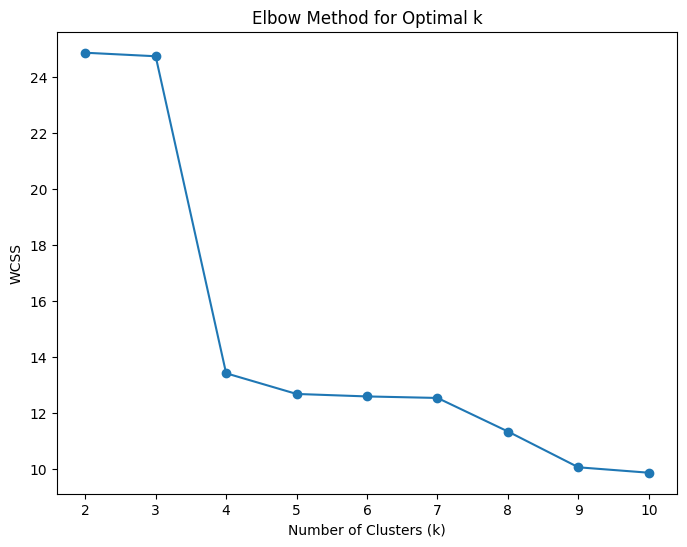

In [622]:
#SEGMENTATION OF ACTIVE CUSTOMER - COLLECT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_ws_filled_seg_active_collect_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_ws_filled_seg_active_collect_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_ws_filled_seg_active_collect_scaled['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_ws_filled_seg_active_collect_scaled.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_ws_filled_seg_active_collect_scaled['Cluster'].value_counts())


WCSS for k=2: 41.797765038404975
WCSS for k=3: 37.60727249485489
WCSS for k=4: 34.95159598978597
WCSS for k=5: 31.497433572018558
WCSS for k=6: 28.246832845618325
WCSS for k=7: 26.012166475961426
WCSS for k=8: 25.68836329682819
WCSS for k=9: 24.414119224011372
WCSS for k=10: 22.81321419324769


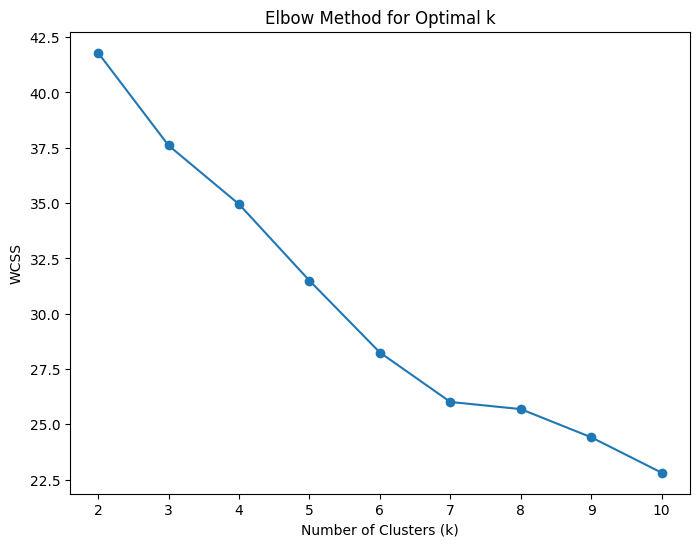


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
             AVG_USD_AMT_ALL_MAKE  FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                   
3457                    0.155729          0.052047                     0.6   
4342                    0.006743          0.008257                     0.0   
3751                    0.008847          0.027763                     0.8   
3308                    0.001763          0.024512                     0.2   
3343                    0.006986          0.003612                     0.2   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
3457                                  0.000000             0.162374   
4342                                  0.454545             0.401102   
3751                                  0.090909             0.547237   
33

In [613]:
#SEGMENTATION OF ACTIVE CUSTOMER - NO COLLECT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_ws_filled_seg_active_nocollect_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_ws_filled_seg_active_nocollect_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_ws_filled_seg_active_nocollect_scaled['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_ws_filled_seg_active_nocollect_scaled.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_ws_filled_seg_active_nocollect_scaled['Cluster'].value_counts())


WCSS for k=2: 72.12908804106881
WCSS for k=3: 68.50235455533239
WCSS for k=4: 67.15188305106422
WCSS for k=5: 66.37030858863656
WCSS for k=6: 37.17875857642687
WCSS for k=7: 34.25750696054258
WCSS for k=8: 34.08176065813363
WCSS for k=9: 34.495029004464726
WCSS for k=10: 34.22529535098134


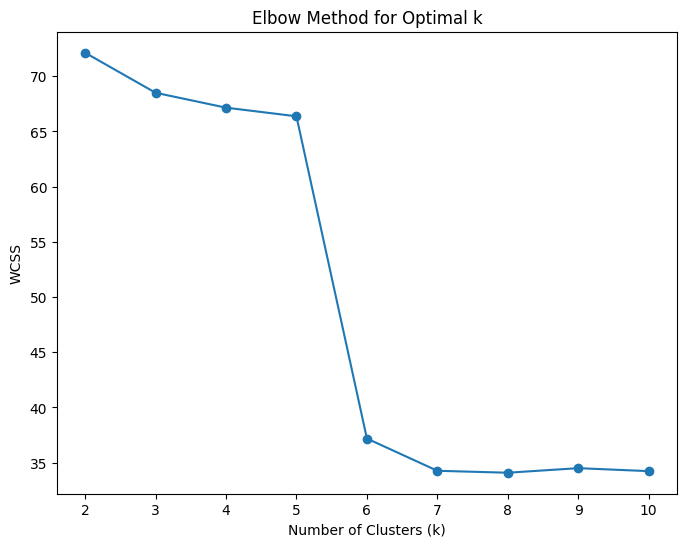

In [614]:
#SEGMENTATION OF LAPSED CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_ws_filled_seg_lapsed_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [615]:
# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 3 # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_ws_filled_seg_lapsed_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_ws_filled_seg_lapsed_scaled['Cluster_Lapsed'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_ws_filled_seg_lapsed_scaled.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_ws_filled_seg_lapsed_scaled['Cluster_Lapsed'].value_counts())



Optimal number of clusters (k) based on the Elbow Method: 3

Clustered Data (first few rows):
             AVG_USD_AMT_ALL_MAKE  FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                   
815                     0.015088          0.083333                     0.2   
1514                    0.029582          0.166667                     0.2   
863                     0.049549          0.083333                     0.2   
3009                    0.035435          0.083333                     0.2   
1010                    0.008681          0.166667                     0.2   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
815                                   0.377049             0.369881   
1514                                  0.540984             0.615604   
863                                   1.000000             0.369881   
30

In [616]:
import pandas as pd

# Assuming df_fnb_segmentation_lapsed and df_fnb_segmentation_active are your dataframes

# Step 1: Create new cluster columns with the combined labels (e.g., lapsed_2, active_2)
df_ws_filled_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_ws_filled_seg_lapsed_scaled['Cluster_Lapsed'].astype(str)
df_ws_filled_seg_active_collect['Combined_Cluster'] = 'active_collect_' + df_ws_filled_seg_active_collect_scaled['Cluster'].astype(str)
df_ws_filled_seg_active_nocollect['Combined_Cluster'] = 'active_nocollect_' + df_ws_filled_seg_active_nocollect_scaled['Cluster'].astype(str)

# Step 3: Keep the original indices when concatenating
df_ws_filled_seg_lapsed_x = df_ws_filled_seg_lapsed.reset_index(drop=False).copy()  # Keep original index as a column
df_ws_filled_seg_active_collect_x = df_ws_filled_seg_active_collect.reset_index(drop=False).copy()  # Keep original index as a column
df_ws_filled_seg_active_nocollect_x = df_ws_filled_seg_active_nocollect.reset_index(drop=False).copy()  # Keep original index as a column

# Step 4: Concatenate the two dataframes along rows (axis=0)
df_ws_filled_seg = pd.concat([df_ws_filled_seg_lapsed_x, df_ws_filled_seg_active_collect_x, df_ws_filled_seg_active_nocollect_x], axis=0, ignore_index=False)

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/141079389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws_filled_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_ws_filled_seg_lapsed_scaled['Cluster_Lapsed'].astype(str)
/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/141079389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ws_filled_seg_active_collect['Combined_Cluster'] = 'active_collect_' + df_ws_filled_seg_active_collect_scaled['Cluster'].astype(str)
/var/

In [617]:
df_ws_filled_seg.set_index('COMPANY_ID', inplace=True)
df_ws_filled_seg = df_ws_filled_seg[['Combined_Cluster']]
df_ws_filled_seg.head()

,Combined_Cluster
COMPANY_ID,
815,lapsed_1
1514,lapsed_2
863,lapsed_0
3009,lapsed_1
1010,lapsed_0


In [618]:
# Reset the index to make COMPANY_ID a column in both dataframes
df_ws_filled_reset = df_ws_filled.reset_index()  # This will move the index to a column
df_ws_filled_seg_reset = df_ws_filled_seg.reset_index()  # Same for df_fnb_segmentation

# Now perform the merge
df_ws_filled = df_ws_filled_reset.merge(df_ws_filled_seg_reset[['COMPANY_ID', 'Combined_Cluster']], on='COMPANY_ID', how='left')

# Optionally, set COMPANY_ID back as the index if you want it to be the index again
df_ws_filled.set_index('COMPANY_ID', inplace=True)

# Display the merged dataframe
df_ws_filled.head()


,AVG_USD_AMT_ALL_MAKE,AVG_REVENUE_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,...,AVG_NET_REVENUE_USD_AMT_ALL_COLLECT,FREQ_ACTIVE_COLLECT,PAYTYPE_COUNT_ALL_COLLECT,SUPPLIER_PAYMENT_PERCENT_COLLECT,RENT_PAYMENT_PERCENT_COLLECT,PAYROLL_PAYMENT_PERCENT_COLLECT,MONTHS_SINCE_FIRST_PAYMENT_ALL_COLLECT,MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC,Combined_Cluster
COMPANY_ID,,,,,,,,,,,,,,,,,,,,,
815,3170.035233090000,58.643556070000,14.599468510000,1.000000,1.0,0.000000,0.000000,0.000000,23.0,23.0,...,0,0,0.0,0,0,0,0.0,0.0,0,lapsed_1
1514,6215.273444248846,109.598524508846,16.213009581154,2.000000,1.0,1.000000,0.000000,0.000000,45.0,33.0,...,0,0,0.0,0,0,0,0.0,0.0,0,lapsed_2
3457,37603.494243895250,707.267845920625,31.627187477875,5.714286,4.0,0.812500,0.000000,0.037500,13.0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,active_nocollect_0
863,10410.403775750000,196.218047960000,-24.694766470000,1.000000,1.0,0.000000,0.000000,0.000000,61.0,61.0,...,0,0,0.0,0,0,0,0.0,0.0,0,lapsed_0
3009,7444.910000000000,96.783830000000,-73.451482060000,1.000000,1.0,1.000000,0.000000,0.000000,17.0,17.0,...,0,0,0.0,0,0,0,0.0,0.0,0,lapsed_1


In [619]:
df_ws_filled.to_csv('ws_clustered.csv')

### Business Svcs Cross-sell and Retain

In [567]:
# Write SQL Snowflake Query here
sql_file = "Industry Seg - EDA - BS.sql"
sql_text = get_sql_file_as_text(sql_file)
my_query=sql_text

In [507]:
# Get data from query above
df_bs = conn.cursor().execute(my_query).fetch_pandas_all()

In [508]:
df_bs.set_index('COMPANY_ID', inplace=True)

In [509]:
#ENCODING OF L2 INDUSTRY

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
df_bs['CU_COMPANY_L2_INDUSTRY_NUMERIC'] = label_encoder.fit_transform(df_bs['CU_COMPANY_L2_INDUSTRY'])

# Drop old var
df_bs = df_bs.drop('CU_COMPANY_L2_INDUSTRY', axis=1)

In [510]:
#IMPUT MISSING VALUE INTO RSD_PERCENTAGE_MAKE

mean_value = df_bs['RSD_PERCENTAGE_MAKE'].mean()
df_bs['RSD_PERCENTAGE_MAKE'].fillna(mean_value, inplace=True)

In [511]:
df_bs.head()

,AVG_USD_AMT_ALL_MAKE,AVG_REVENUE_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,ENTITY_NAME,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,,,
784,5092.132317250000,91.088473850000,25.651437405000,2.000000,1,0.000000,1.000000,0.000000,1,1,0.959170,0,DAES OMNI PTE. LTD.,2
2234,14405.596849508333,369.556646671667,30.365306253333,1.000000,1,0.000000,1.000000,0.000000,31,26,1.044473,0,ACTIVE FITNESS (PTE. LTD.),2
3669,5257.287376758621,97.032592682414,28.128153585172,4.833333,1,0.000000,0.000000,1.000000,11,0,0.602422,0,DENNIS GYM PTE. LTD.,2
3525,1933.892303236667,23.220674290000,-11.532165590000,0.230769,2,0.000000,0.000000,0.000000,13,1,0.959170,0,TIGER KING SERVICES PTE. LTD.,8
1494,819.706925730000,0E-12,-20.525616870000,1.000000,1,0.000000,0.000000,0.000000,45,45,0.959170,0,MYCROSS PTE. LTD.,4


In [512]:
df_bs_seg = df_bs[['AVG_USD_AMT_ALL_MAKE',
                              'FREQ_ACTIVE_MAKE',
                              'PAYTYPE_COUNT_ALL_MAKE',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE',
                              'RSD_PERCENTAGE_MAKE',
                              'USE_COLLECT']].copy()

In [513]:
df_bs_seg_lapsed = df_bs_seg[df_bs_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] > 12]
df_bs_seg_active = df_bs_seg[df_bs_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] <= 12]

df_bs_seg_active_collect = df_bs_seg_active[df_bs_seg_active['USE_COLLECT'] == 1]
df_bs_seg_active_nocollect = df_bs_seg_active[df_bs_seg_active['USE_COLLECT'] != 1]

In [514]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Min-max scale the numerical columns in df_fnb_numerical
df_bs_seg_active_collect_scaled = pd.DataFrame(scaler.fit_transform(df_bs_seg_active_collect),
                                                 columns=df_bs_seg_active_collect.columns,
                                                 index=df_bs_seg_active_collect.index)

# Min-max scale the numerical columns in df_fnb_numerical
df_bs_seg_active_nocollect_scaled = pd.DataFrame(scaler.fit_transform(df_bs_seg_active_nocollect),
                                                 columns=df_bs_seg_active_nocollect.columns,
                                                 index=df_bs_seg_active_nocollect.index)

# Min-max scale the numerical columns in df_fnb_numerical
df_bs_seg_lapsed_scaled = pd.DataFrame(scaler.fit_transform(df_bs_seg_lapsed),
                                                 columns=df_bs_seg_lapsed.columns,
                                                 index=df_bs_seg_lapsed.index)

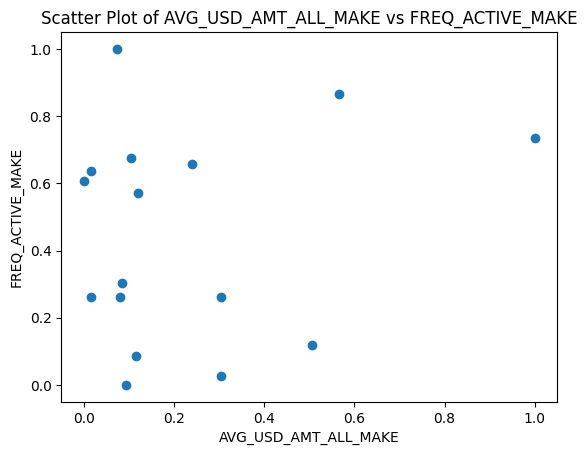

In [518]:
#PLOT COLLECT ACTIVE

import matplotlib.pyplot as plt

# Extract the required columns from the DataFrame
x = df_bs_seg_active_collect_scaled['AVG_USD_AMT_ALL_MAKE']
y = df_bs_seg_active_collect_scaled['FREQ_ACTIVE_MAKE']

# Create the scatterplot
plt.scatter(x, y)
plt.xlabel('AVG_USD_AMT_ALL_MAKE')
plt.ylabel('FREQ_ACTIVE_MAKE')
plt.title('Scatter Plot of AVG_USD_AMT_ALL_MAKE vs FREQ_ACTIVE_MAKE')
plt.show()

WCSS for k=2: 81.42820880552526
WCSS for k=3: 77.1567922422048
WCSS for k=4: 73.14487067655506
WCSS for k=5: 73.56840106883769
WCSS for k=6: 63.28947979710233
WCSS for k=7: 62.41659389982526
WCSS for k=8: 58.97156715219528
WCSS for k=9: 57.760197336590025
WCSS for k=10: 56.795729837576594


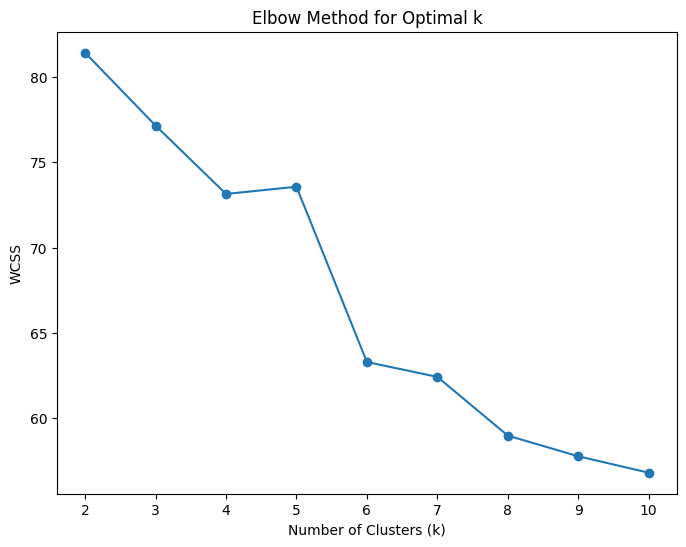


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
4260          1350.196469416667         1.200000                       2   
3461          3808.393829603000         0.666667                       2   
3669          5257.287376758621         4.833333                       1   
3525          1933.892303236667         0.230769                       2   
2372          1253.693552550820         4.066667                       6   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
4260                                         0             0.078395   
3461                                         0             0.803116   
3669                                         0             0.602422   
3525            

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2500931955.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_active['Cluster'] = labels


In [500]:
#SEGMENTATION OF ACTIVE CUSTOMER - COLLECT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_bs_seg_active_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_bs_seg_active_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_bs_seg_active['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_bs_seg_active.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_bs_seg_active['Cluster'].value_counts())


WCSS for k=2: 59.94678837011094
WCSS for k=3: 54.2004548311976
WCSS for k=4: 52.47249243683471
WCSS for k=5: 50.70573257051522
WCSS for k=6: 43.52794971038942
WCSS for k=7: 44.355644591357546
WCSS for k=8: 43.67532443472829
WCSS for k=9: 43.11511425633959
WCSS for k=10: 43.334186519910745


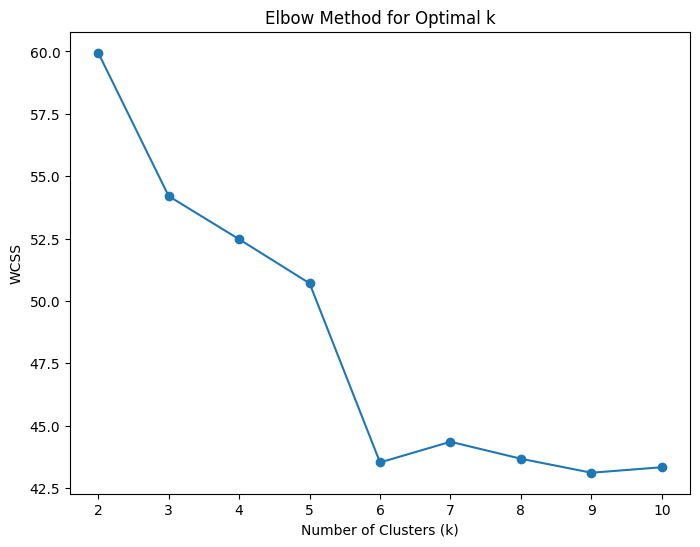


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
2317          3970.618666666667         1.000000                       1   
1494           819.706925730000         1.000000                       1   
2234         14405.596849508333         1.000000                       1   
2331          2541.259405661429         0.538462                       3   
2899         16344.503299630000         1.000000                       1   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE  RSD_PERCENTAGE_MAKE  \
COMPANY_ID                                                            
2317                                        28             1.818466   
1494                                        45             0.959170   
2234                                        26             1.044473   
2331            

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/406693318.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_lapsed['Cluster_Lapsed'] = labels


In [501]:
#SEGMENTATION OF LAPSED CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_bs_seg_lapsed_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_bs_seg_lapsed_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_bs_seg_lapsed['Cluster_Lapsed'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_bs_seg_lapsed.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_bs_seg_lapsed['Cluster_Lapsed'].value_counts())


In [502]:
import pandas as pd

# Assuming df_fnb_segmentation_lapsed and df_fnb_segmentation_active are your dataframes

# Step 1: Create new cluster columns with the combined labels (e.g., lapsed_2, active_2)
df_bs_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_bs_seg_lapsed['Cluster_Lapsed'].astype(str)
df_bs_seg_active['Combined_Cluster'] = 'active_' + df_bs_seg_active['Cluster'].astype(str)

# Step 3: Keep the original indices when concatenating
df_bs_seg_lapsed_x = df_bs_seg_lapsed.reset_index(drop=False).copy()  # Keep original index as a column
df_bs_seg_active_x = df_bs_seg_active.reset_index(drop=False).copy()  # Keep original index as a column

# Step 4: Concatenate the two dataframes along rows (axis=0)
df_bs_seg = pd.concat([df_bs_seg_lapsed_x, df_bs_seg_active_x], axis=0, ignore_index=False)

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2725837510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_bs_seg_lapsed['Cluster_Lapsed'].astype(str)
/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2725837510.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_active['Combined_Cluster'] = 'active_' + df_bs_seg_active['Cluster'].astype(str)


In [503]:
df_bs_seg.set_index('COMPANY_ID', inplace=True)
df_bs_seg = df_bs_seg[['Combined_Cluster']]
df_bs_seg.head()

,Combined_Cluster
COMPANY_ID,
2317,lapsed_2
1494,lapsed_0
2234,lapsed_3
2331,lapsed_3
2899,lapsed_3


In [504]:
# Reset the index to make COMPANY_ID a column in both dataframes
df_bs_reset = df_bs.reset_index()  # This will move the index to a column
df_bs_seg_reset = df_bs_seg.reset_index()  # Same for df_fnb_segmentation

# Now perform the merge
df_bs = df_bs_reset.merge(df_bs_seg_reset[['COMPANY_ID', 'Combined_Cluster']], on='COMPANY_ID', how='left')

# Optionally, set COMPANY_ID back as the index if you want it to be the index again
df_bs.set_index('COMPANY_ID', inplace=True)

# Display the merged dataframe
df_bs.head()

,AVG_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,RSD_PERCENTAGE_MAKE,USE_COLLECT,ENTITY_NAME,CU_COMPANY_L2_INDUSTRY_NUMERIC,Combined_Cluster
COMPANY_ID,,,,,,,,,,,,,,
4260,1350.196469416667,5.429821026667,1.200000,2,0.000000,0.833333,0.000000,4,0,0.078395,0,LIGHTQUEST PTE. LTD.,4,active_1
2317,3970.618666666667,29.367688313333,1.000000,1,0.000000,0.000000,1.000000,30,28,1.818466,0,MEDIA UNBOXXED PTE. LTD.,6,lapsed_2
3461,3808.393829603000,15.008194069000,0.666667,2,0.100000,0.900000,0.000000,14,0,0.803116,0,ASCENXIO FINANCIAL PTE. LTD.,4,active_1
3669,5257.287376758621,28.128153585172,4.833333,1,0.000000,0.000000,1.000000,11,0,0.602422,0,DENNIS GYM PTE. LTD.,2,active_1
1494,819.706925730000,-20.525616870000,1.000000,1,0.000000,0.000000,0.000000,45,45,0.959170,0,MYCROSS PTE. LTD.,4,lapsed_0


In [505]:
df_bs.to_csv('bs_clustered.csv')

### Business Svcs Retain only

In [635]:
# Write SQL Snowflake Query here
sql_file = "Industry Seg - EDA - BS.sql"
sql_text = get_sql_file_as_text(sql_file)
my_query=sql_text

In [636]:
# Get data from query above
df_bs = conn.cursor().execute(my_query).fetch_pandas_all()

In [637]:
df_bs.set_index('COMPANY_ID', inplace=True)

In [638]:
#ENCODING OF L2 INDUSTRY

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
df_bs['CU_COMPANY_L2_INDUSTRY_NUMERIC'] = label_encoder.fit_transform(df_bs['CU_COMPANY_L2_INDUSTRY'])

# Drop old var
df_bs = df_bs.drop('CU_COMPANY_L2_INDUSTRY', axis=1)

In [639]:
#IMPUT MISSING VALUE INTO RSD_PERCENTAGE_MAKE

mean_value = df_bs['RSD_PERCENTAGE_MAKE'].mean()
df_bs['RSD_PERCENTAGE_MAKE'].fillna(mean_value, inplace=True)

In [640]:
df_bs.head()

,AVG_USD_AMT_ALL_MAKE,AVG_REVENUE_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,...,AVG_REVENUE_USD_AMT_ALL_COLLECT,AVG_NET_REVENUE_USD_AMT_ALL_COLLECT,FREQ_ACTIVE_COLLECT,PAYTYPE_COUNT_ALL_COLLECT,SUPPLIER_PAYMENT_PERCENT_COLLECT,RENT_PAYMENT_PERCENT_COLLECT,PAYROLL_PAYMENT_PERCENT_COLLECT,MONTHS_SINCE_FIRST_PAYMENT_ALL_COLLECT,MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC
COMPANY_ID,,,,,,,,,,,,,,,,,,,,,
1052,744.491000000000,10.795119500000,-4.355272350000,1.000000,1.0,0.000000,0.000000,1.000000,58.0,58.0,...,None,None,None,NaN,None,None,None,NaN,NaN,4
2279,None,None,None,None,NaN,None,None,None,NaN,NaN,...,0E-12,-0.379690410000,1.000000,1.0,1.000000,0.000000,0.000000,31.0,31.0,6
1984,7977.302959010000,119.662038430000,8.613760870000,1.000000,1.0,1.000000,0.000000,0.000000,35.0,35.0,...,None,None,None,NaN,None,None,None,NaN,NaN,11
2234,14405.596849508333,369.556646671667,30.365306253333,1.000000,1.0,0.000000,1.000000,0.000000,31.0,26.0,...,None,None,None,NaN,None,None,None,NaN,NaN,2
784,6789.509756333333,148.990020556667,26.960500746667,1.500000,1.0,0.000000,1.000000,0.000000,1.0,0.0,...,None,None,None,NaN,None,None,None,NaN,NaN,2


In [641]:
df_bs_seg = df_bs[['AVG_USD_AMT_ALL_MAKE',
                              'FREQ_ACTIVE_MAKE',
                              'PAYTYPE_COUNT_ALL_MAKE',
                              'MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE',
                              'SUPPLIER_PAYMENT_PERCENT_MAKE',
                              'RENT_PAYMENT_PERCENT_MAKE',
                              'PAYROLL_PAYMENT_PERCENT_MAKE'
    ]].copy()

In [642]:
df_bs_seg.dropna(inplace=True)

In [644]:
df_bs_seg_lapsed = df_bs_seg[df_bs_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] > 12]
df_bs_seg_active = df_bs_seg[df_bs_seg['MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE'] <= 12]

In [647]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Min-max scale the numerical columns in df_fnb_numerical
df_bs_seg_active_scaled = pd.DataFrame(scaler.fit_transform(df_bs_seg_active),
                                                 columns=df_bs_seg_active.columns,
                                                 index=df_bs_seg_active.index)

# Min-max scale the numerical columns in df_fnb_numerical
df_bs_seg_lapsed_scaled = pd.DataFrame(scaler.fit_transform(df_bs_seg_lapsed),
                                                 columns=df_bs_seg_lapsed.columns,
                                                 index=df_bs_seg_lapsed.index)

WCSS for k=2: 168.45578237868133
WCSS for k=3: 112.94351924763278
WCSS for k=4: 96.44605742072119
WCSS for k=5: 91.10433673515354
WCSS for k=6: 82.32269302761277
WCSS for k=7: 78.458867414319
WCSS for k=8: 73.0117121005069
WCSS for k=9: 74.26395220955939
WCSS for k=10: 72.6459225532061


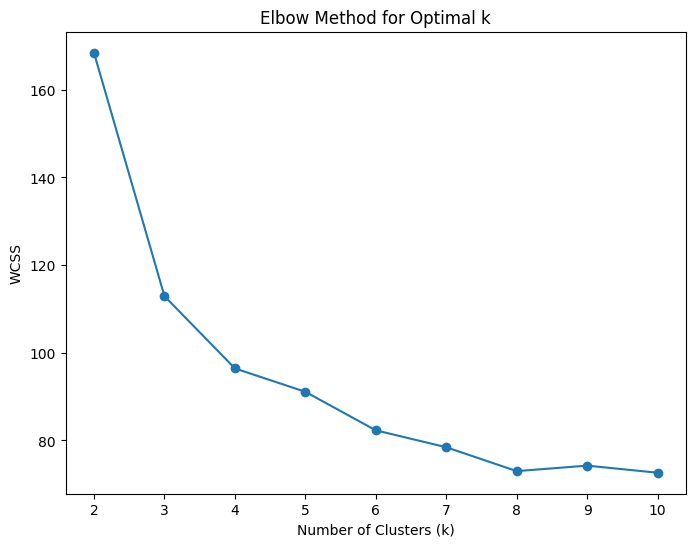


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
784           6789.509756333333         1.500000                     1.0   
4054          9110.336367000000         1.000000                     1.0   
2238          1567.635552882903         0.968750                     1.0   
2160          1863.932629945294         0.531250                     3.0   
1066         20946.256227150435         0.418182                     2.0   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE SUPPLIER_PAYMENT_PERCENT_MAKE  \
COMPANY_ID                                                                     
784                                        0.0                      0.000000   
4054                                       3.0                      0.000000   
2238                                       0.0     

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2500931955.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_active['Cluster'] = labels


In [651]:
#SEGMENTATION OF ACTIVE CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_bs_seg_active_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_bs_seg_active_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_bs_seg_active['Cluster'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_bs_seg_active.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_bs_seg_active['Cluster'].value_counts())


WCSS for k=2: 120.76541827373758
WCSS for k=3: 110.24071512468666
WCSS for k=4: 80.3040030071902
WCSS for k=5: 76.26853398259111
WCSS for k=6: 58.04127744192729
WCSS for k=7: 53.484133526755926
WCSS for k=8: 54.6526024763624
WCSS for k=9: 51.83292382920308
WCSS for k=10: 51.31158362689479


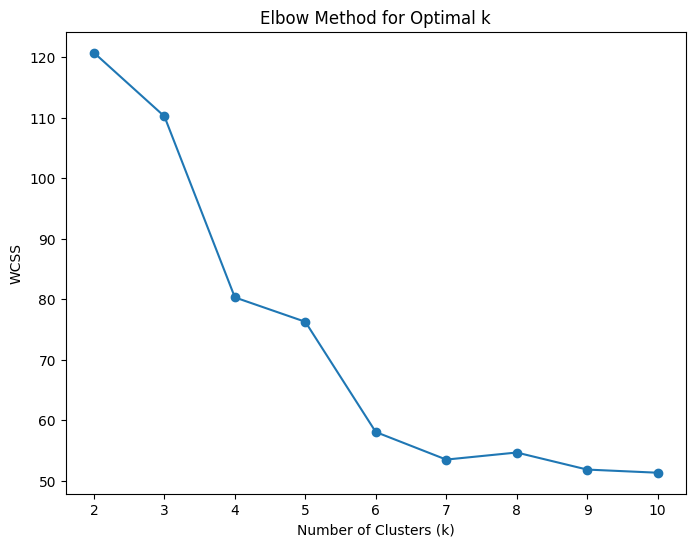


Optimal number of clusters (k) based on the Elbow Method: 4

Clustered Data (first few rows):
            AVG_USD_AMT_ALL_MAKE FREQ_ACTIVE_MAKE  PAYTYPE_COUNT_ALL_MAKE  \
COMPANY_ID                                                                 
1052           744.491000000000         1.000000                     1.0   
1984          7977.302959010000         1.000000                     1.0   
2234         14405.596849508333         1.000000                     1.0   
2899         16344.503299630000         1.000000                     1.0   
2331          2541.259405661429         0.538462                     3.0   

            MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE SUPPLIER_PAYMENT_PERCENT_MAKE  \
COMPANY_ID                                                                     
1052                                      58.0                      0.000000   
1984                                      35.0                      1.000000   
2234                                      26.0     

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/406693318.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_lapsed['Cluster_Lapsed'] = labels


In [653]:
#SEGMENTATION OF LAPSED CUSTOMER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Step 1: Preprocess data (Assuming df_fnb_segmentation_scaled is already scaled)
# If not, you can scale it using StandardScaler
# scaler = StandardScaler()
# df_fnb_segmentation_scaled = scaler.fit_transform(df_fnb_segmentation)

# Step 2: Find the optimal number of clusters (k) using the Elbow Method
wcss = []  # List to store the WCSS values for each k
k_range = range(2, 11)  # Test from 2 to 10 clusters

for k in k_range:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(df_bs_seg_lapsed_scaled)
    # Calculate WCSS (within-cluster sum of squared distances)
    wcss.append(kmedoids.inertia_)
    print(f"WCSS for k={k}: {kmedoids.inertia_}")

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Step 4: Select the best k based on the Elbow Curve
# Look for the "elbow" point in the plot manually or use domain knowledge to choose a k
best_k = 4  # This is an example value, adjust it based on the Elbow plot
print(f"\nOptimal number of clusters (k) based on the Elbow Method: {best_k}")

# Step 5: Fit KMedoids with the selected k
kmedoids_final = KMedoids(n_clusters=best_k, random_state=42)
kmedoids_final.fit(df_bs_seg_lapsed_scaled)

# Step 6: Assign cluster labels to the data
labels = kmedoids_final.labels_

# Step 7: View the final clustering results
df_bs_seg_lapsed['Cluster_Lapsed'] = labels

# Display the clusters
print("\nClustered Data (first few rows):\n", df_bs_seg_lapsed.head())

# Optional: Class distribution of the clusters
print("\nCluster Sizes:")
print(df_bs_seg_lapsed['Cluster_Lapsed'].value_counts())


In [654]:
import pandas as pd

# Assuming df_fnb_segmentation_lapsed and df_fnb_segmentation_active are your dataframes

# Step 1: Create new cluster columns with the combined labels (e.g., lapsed_2, active_2)
df_bs_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_bs_seg_lapsed['Cluster_Lapsed'].astype(str)
df_bs_seg_active['Combined_Cluster'] = 'active_' + df_bs_seg_active['Cluster'].astype(str)

# Step 3: Keep the original indices when concatenating
df_bs_seg_lapsed_x = df_bs_seg_lapsed.reset_index(drop=False).copy()  # Keep original index as a column
df_bs_seg_active_x = df_bs_seg_active.reset_index(drop=False).copy()  # Keep original index as a column

# Step 4: Concatenate the two dataframes along rows (axis=0)
df_bs_seg = pd.concat([df_bs_seg_lapsed_x, df_bs_seg_active_x], axis=0, ignore_index=False)

/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2725837510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_lapsed['Combined_Cluster'] = 'lapsed_' + df_bs_seg_lapsed['Cluster_Lapsed'].astype(str)
/var/folders/sp/wnd46psj0r5_ys790_zv7xgm0000gr/T/ipykernel_9702/2725837510.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_seg_active['Combined_Cluster'] = 'active_' + df_bs_seg_active['Cluster'].astype(str)


In [655]:
df_bs_seg.set_index('COMPANY_ID', inplace=True)
df_bs_seg = df_bs_seg[['Combined_Cluster']]
df_bs_seg.head()

,Combined_Cluster
COMPANY_ID,
1052,lapsed_3
1984,lapsed_1
2234,lapsed_0
2899,lapsed_3
2331,lapsed_3


In [656]:
# Reset the index to make COMPANY_ID a column in both dataframes
df_bs_reset = df_bs.reset_index()  # This will move the index to a column
df_bs_seg_reset = df_bs_seg.reset_index()  # Same for df_fnb_segmentation

# Now perform the merge
df_bs = df_bs_reset.merge(df_bs_seg_reset[['COMPANY_ID', 'Combined_Cluster']], on='COMPANY_ID', how='left')

# Optionally, set COMPANY_ID back as the index if you want it to be the index again
df_bs.set_index('COMPANY_ID', inplace=True)

# Display the merged dataframe
df_bs.head()

,AVG_USD_AMT_ALL_MAKE,AVG_REVENUE_USD_AMT_ALL_MAKE,AVG_NET_REVENUE_USD_AMT_ALL_MAKE,FREQ_ACTIVE_MAKE,PAYTYPE_COUNT_ALL_MAKE,SUPPLIER_PAYMENT_PERCENT_MAKE,RENT_PAYMENT_PERCENT_MAKE,PAYROLL_PAYMENT_PERCENT_MAKE,MONTHS_SINCE_FIRST_PAYMENT_ALL_MAKE,MONTHS_SINCE_LAST_PAYMENT_ALL_MAKE,...,AVG_NET_REVENUE_USD_AMT_ALL_COLLECT,FREQ_ACTIVE_COLLECT,PAYTYPE_COUNT_ALL_COLLECT,SUPPLIER_PAYMENT_PERCENT_COLLECT,RENT_PAYMENT_PERCENT_COLLECT,PAYROLL_PAYMENT_PERCENT_COLLECT,MONTHS_SINCE_FIRST_PAYMENT_ALL_COLLECT,MONTHS_SINCE_LAST_PAYMENT_ALL_COLLECT,CU_COMPANY_L2_INDUSTRY_NUMERIC,Combined_Cluster
COMPANY_ID,,,,,,,,,,,,,,,,,,,,,
1052,744.491000000000,10.795119500000,-4.355272350000,1.000000,1.0,0.000000,0.000000,1.000000,58.0,58.0,...,None,None,NaN,None,None,None,NaN,NaN,4,lapsed_3
2279,None,None,None,None,NaN,None,None,None,NaN,NaN,...,-0.379690410000,1.000000,1.0,1.000000,0.000000,0.000000,31.0,31.0,6,NaN
1984,7977.302959010000,119.662038430000,8.613760870000,1.000000,1.0,1.000000,0.000000,0.000000,35.0,35.0,...,None,None,NaN,None,None,None,NaN,NaN,11,lapsed_1
2234,14405.596849508333,369.556646671667,30.365306253333,1.000000,1.0,0.000000,1.000000,0.000000,31.0,26.0,...,None,None,NaN,None,None,None,NaN,NaN,2,lapsed_0
784,6789.509756333333,148.990020556667,26.960500746667,1.500000,1.0,0.000000,1.000000,0.000000,1.0,0.0,...,None,None,NaN,None,None,None,NaN,NaN,2,active_0


In [657]:
df_bs.to_csv('bs_clustered.csv')